In [4]:
#!pip install fedot

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"

import torch
torch.set_num_threads(10)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [6]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [21]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()
ts_real_traffic = ts_tabular[ts_tabular['label']=='traffic_volume'].drop('label',axis=1)['value'].to_numpy()

In [8]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [52]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 2000
end = 3000
series = 'traffic'

if series == 'traffic':
  init_series = ts_real_traffic
  ts = init_series[start:end]
  trend = None
  ts_test = init_series[end:end+horizon]
  trend_test = None

if series == 'temp':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

In [46]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-24 18:57:33,515 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 18:57:33,526 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:57:33,532 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 18:57:33,535 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:57:33,539 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-24 18:57:33,542 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-24 18:57:33,655 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:57:33,727 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:57:33,741 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:57:33,753 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:57:33,762 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:57:33,773 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:57:33,785 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-24 18:57:33,799 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.3 sec.


2022-11-24 18:57:33,809 - ApiComposer - Initial pipeline was fitted in 0.3 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


2022-11-24 18:57:33,831 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-24 18:57:33,855 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-24 18:57:33,862 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:57:33,889 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-24 18:57:34,586 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1095.4537189760804, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:57:34,593 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1095.4537189760804, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 18:57:34,596 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.0 min


2022-11-24 18:57:34,599 - EvoGraphOptimizer - spent time: 0.0 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:57:36,062 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-24 18:58:32,627 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 908.7445286961133, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:58:32,631 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 908.7445286961133, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 18:58:32,637 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2022-11-24 18:58:32,641 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-24 18:58:32,645 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:58:33,541 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-24 18:58:46,457 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 908.7445286961133, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:58:46,465 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 908.7445286961133, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-24 18:58:46,469 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2022-11-24 18:58:46,472 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 5


2022-11-24 18:58:46,476 - EvoGraphOptimizer - Next population size: 55; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:58:47,743 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-24 19:00:16,173 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 895.5671453386576, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


2022-11-24 19:00:16,182 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 895.5671453386576, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.7}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 19:00:16,187 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.7 min


2022-11-24 19:00:16,191 - EvoGraphOptimizer - spent time: 2.7 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2022-11-24 19:00:16,195 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:  33%|███▎      | 1/3 [02:42<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 2.706 min


2022-11-24 19:00:16,201 - OptimisationTimer - Composition time: 2.706 min


INFO:root:OptimisationTimer - Algorithm was terminated due to processing time limit


2022-11-24 19:00:16,205 - OptimisationTimer - Algorithm was terminated due to processing time limit


INFO:root:GPComposer - GP composition finished


2022-11-24 19:00:16,214 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-24 19:00:16,608 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-24 19:00:31,604 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 6, 'length': 7, 'nodes': [adareg, ridge, lagged, ridge, lagged, linear, decompose]}


2022-11-24 19:00:31,612 - FEDOT logger - Final pipeline: {'depth': 6, 'length': 7, 'nodes': [adareg, ridge, lagged, ridge, lagged, linear, decompose]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: adareg


2022-11-24 19:00:31,624 - SecondaryNode - Obtain prediction in secondary node with operation: adareg


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: adareg


2022-11-24 19:00:31,628 - SecondaryNode - Fit all parent nodes in secondary node with operation: adareg


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: linear


2022-11-24 19:00:31,634 - SecondaryNode - Obtain prediction in secondary node with operation: linear


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: linear


2022-11-24 19:00:31,640 - SecondaryNode - Fit all parent nodes in secondary node with operation: linear


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: decompose


2022-11-24 19:00:31,646 - SecondaryNode - Obtain prediction in secondary node with operation: decompose


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: decompose


2022-11-24 19:00:31,649 - SecondaryNode - Fit all parent nodes in secondary node with operation: decompose


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 19:00:31,656 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 19:00:31,660 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 19:00:31,663 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 19:00:31,666 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 19:00:31,669 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 19:00:31,674 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 19:00:31,680 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 19:00:31,687 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 19:00:31,693 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 19:00:31,696 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 19:00:31,699 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 19:00:31,702 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 19:00:31,707 - PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 19:00:31,931 - OperationTypesRepository - Operation lagged not found in the repository


2022-11-24 19:00:31,937 - OperationTypesRepository - Operation lagged not found in the repository


2022-11-24 19:00:31,942 - OperationTypesRepository - Operation decompose not found in the repository


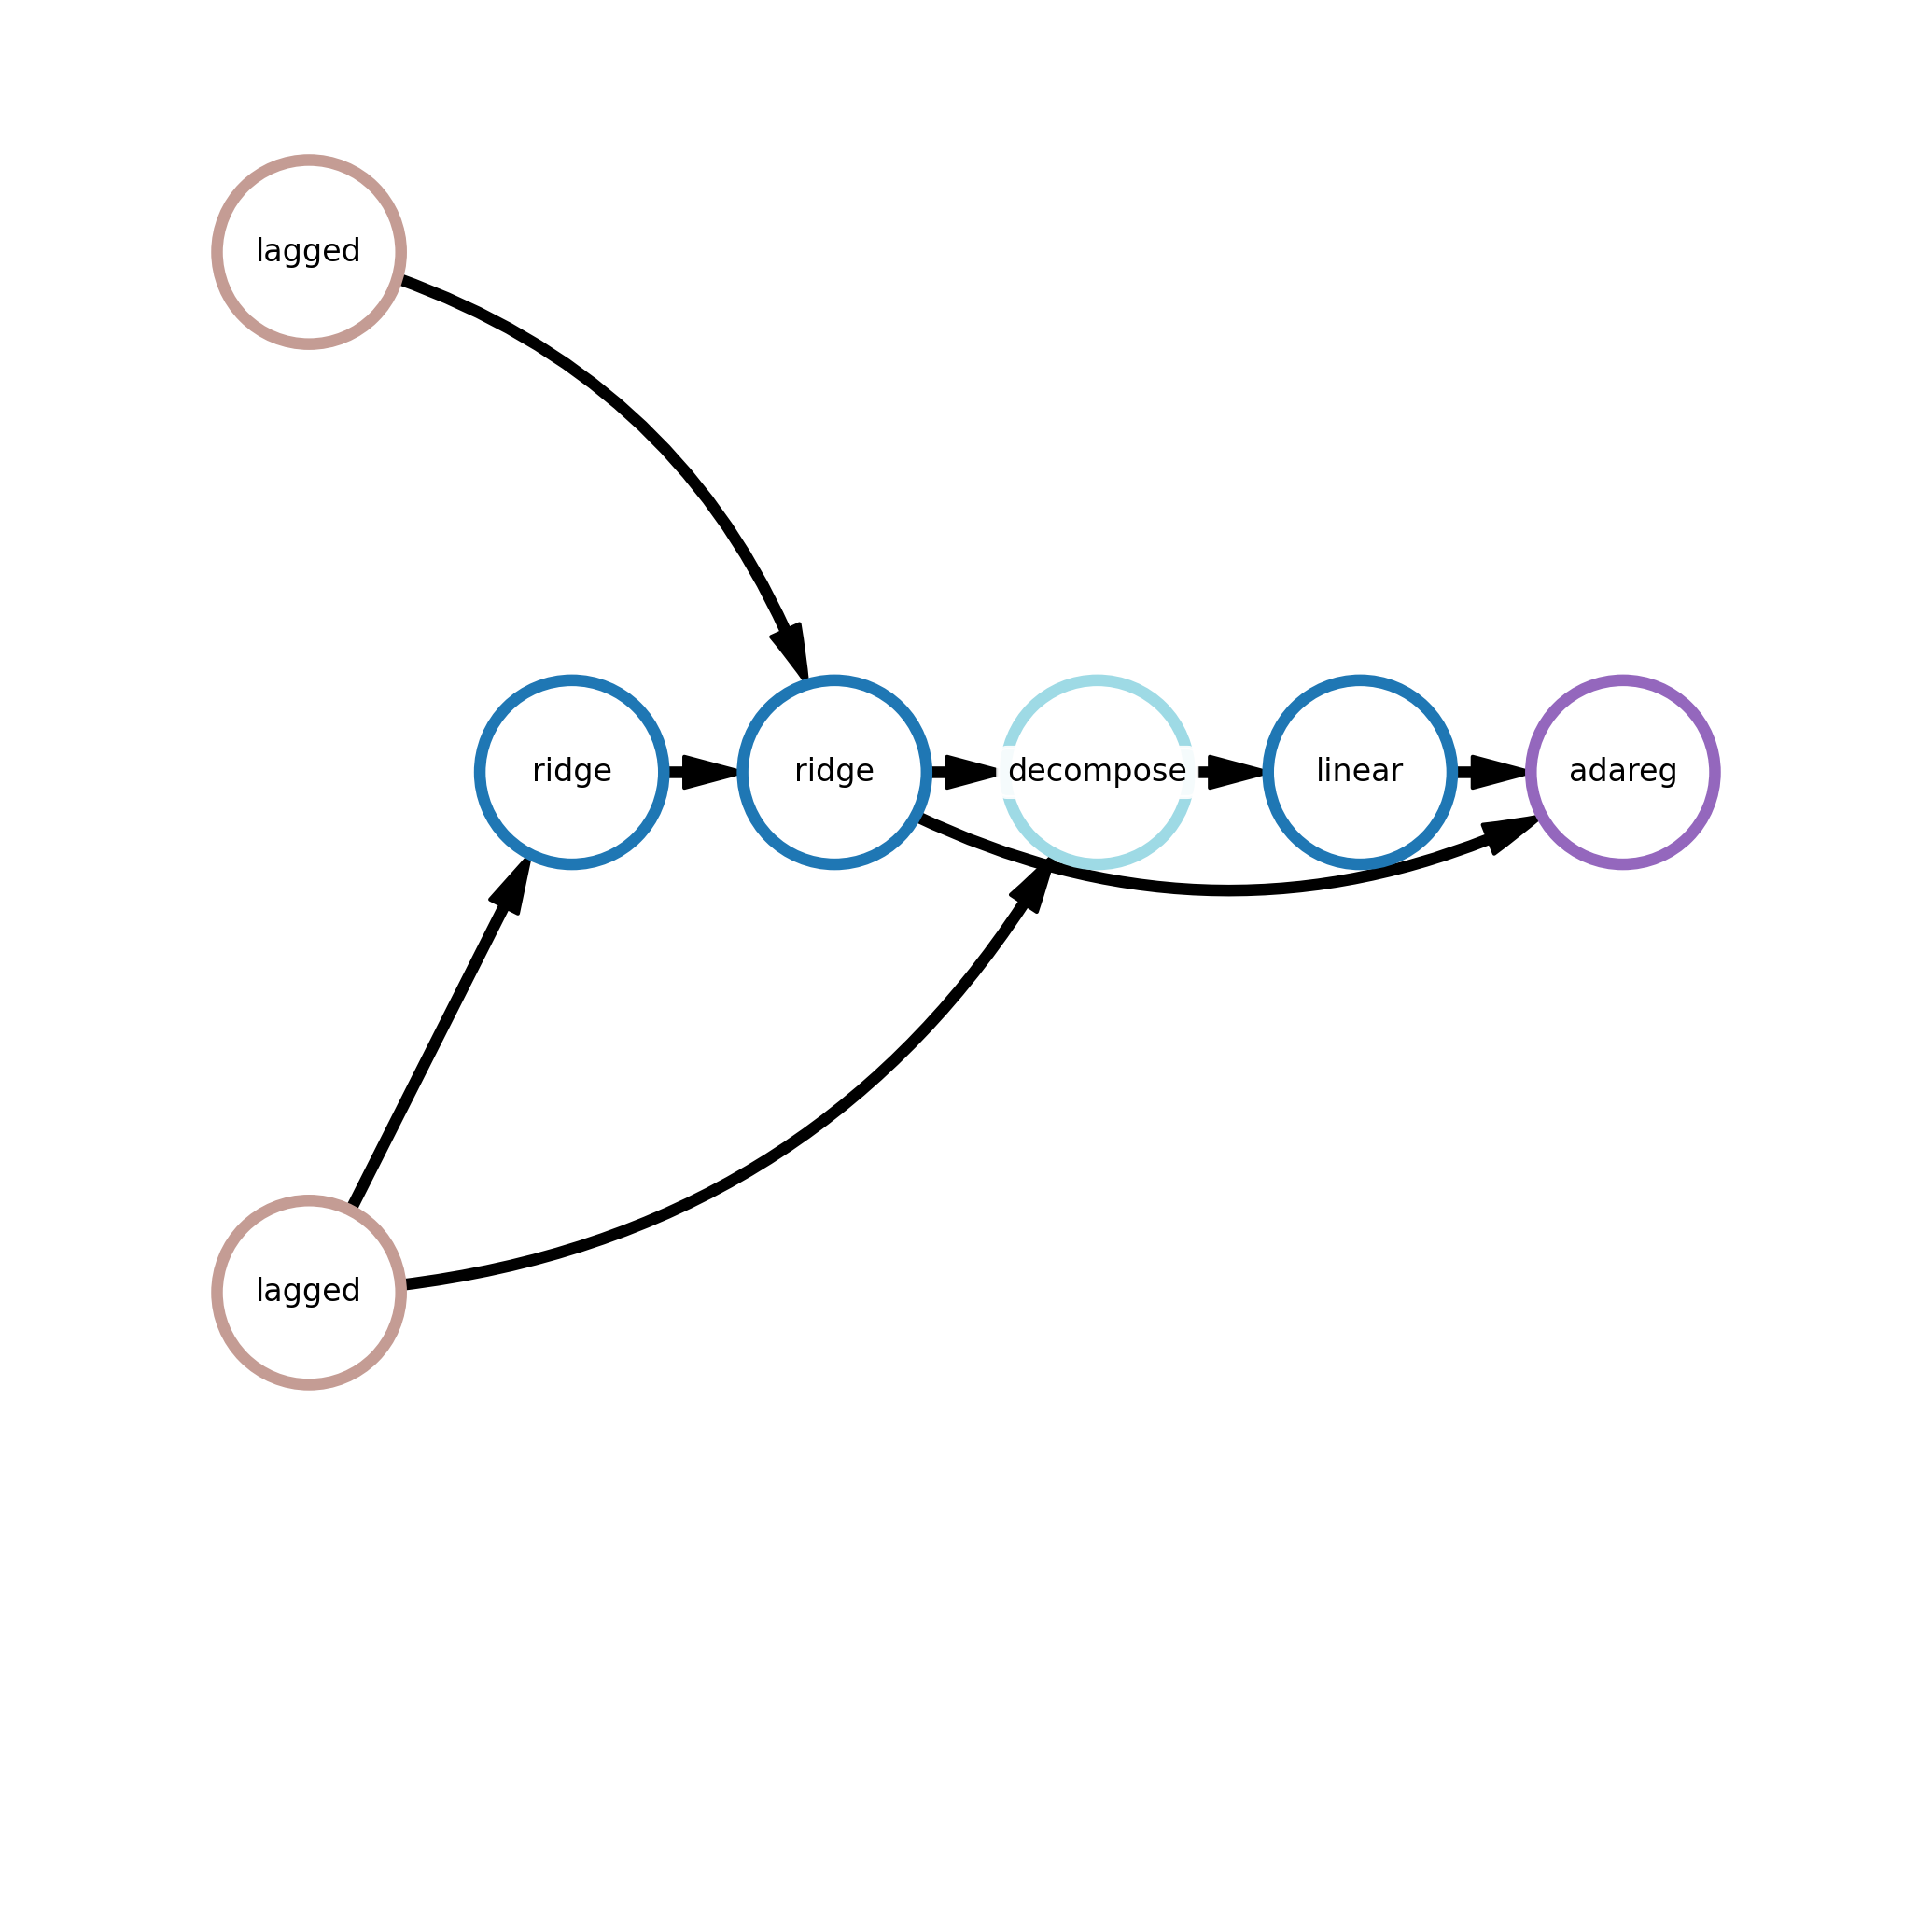

In [54]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

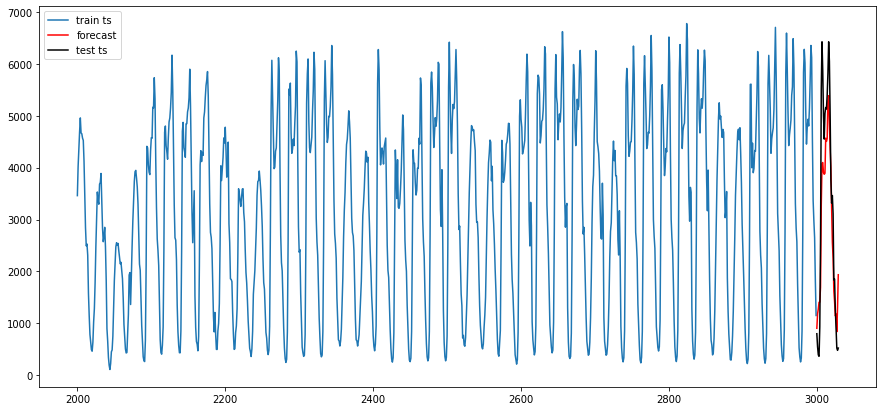

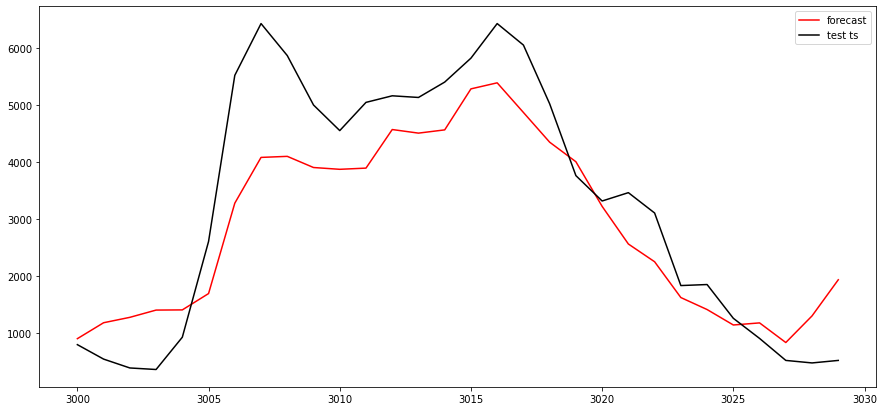

In [55]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [56]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [57]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 19:03:19,456 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 19:03:19,468 - DataSourceSplitter - Hold out validation is applied.


In [58]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [59]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [60]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [61]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-24 19:03:27,196 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007907 seconds


2022-11-24 19:03:42,656 - build_posterior_wrapper took 0.007907 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:03:42,661 - TPE using 0 trials
 10%|█         | 1/10 [00:39<05:57, 39.77s/trial, best loss: 290.58543242439]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007705 seconds


2022-11-24 19:04:22,430 - build_posterior_wrapper took 0.007705 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 290.585432


2022-11-24 19:04:22,438 - TPE using 1/1 trials with best loss 290.585432
 20%|██        | 2/10 [01:16<05:03, 37.99s/trial, best loss: 141.75075572901443]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008264 seconds


2022-11-24 19:04:59,176 - build_posterior_wrapper took 0.008264 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 141.750756


2022-11-24 19:04:59,183 - TPE using 2/2 trials with best loss 141.750756
 30%|███       | 3/10 [01:38<03:34, 30.67s/trial, best loss: 131.82286692119663]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004373 seconds


2022-11-24 19:05:21,119 - build_posterior_wrapper took 0.004373 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 131.822867


2022-11-24 19:05:21,126 - TPE using 3/3 trials with best loss 131.822867
 40%|████      | 4/10 [02:18<03:27, 34.55s/trial, best loss: 131.82286692119663]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:06:22,106 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 129.850 equal or better than initial (+ 5% deviation) 214.714


2022-11-24 19:06:22,116 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 129.850 equal or better than initial (+ 5% deviation) 214.714


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:06:25,514 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006540 seconds


2022-11-24 19:06:46,988 - build_posterior_wrapper took 0.006540 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:06:46,993 - TPE using 0 trials
 10%|█         | 1/10 [00:38<05:48, 38.72s/trial, best loss: 270.81157154254464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007954 seconds


2022-11-24 19:07:25,709 - build_posterior_wrapper took 0.007954 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 270.811572


2022-11-24 19:07:25,715 - TPE using 1/1 trials with best loss 270.811572
 20%|██        | 2/10 [01:00<03:50, 28.76s/trial, best loss: 249.49616662557392]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009613 seconds


2022-11-24 19:07:47,506 - build_posterior_wrapper took 0.009613 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 249.496167


2022-11-24 19:07:47,513 - TPE using 2/2 trials with best loss 249.496167
 30%|███       | 3/10 [01:33<03:34, 30.63s/trial, best loss: 236.79895946135423]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007292 seconds


2022-11-24 19:08:20,362 - build_posterior_wrapper took 0.007292 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 236.798959


2022-11-24 19:08:20,368 - TPE using 3/3 trials with best loss 236.798959
 40%|████      | 4/10 [02:01<03:02, 30.45s/trial, best loss: 236.79895946135423]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:09:21,739 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 235.002 worse than initial (+ 5% deviation) 214.856


2022-11-24 19:09:21,748 - PipelineTuner - Return init pipeline due to the fact that obtained metric 235.002 worse than initial (+ 5% deviation) 214.856


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-24 19:09:24,827 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005783 seconds


2022-11-24 19:09:39,544 - build_posterior_wrapper took 0.005783 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:09:39,553 - TPE using 0 trials
 10%|█         | 1/10 [00:31<04:47, 31.91s/trial, best loss: 128.93361508847386]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003712 seconds


2022-11-24 19:10:11,459 - build_posterior_wrapper took 0.003712 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 128.933615


2022-11-24 19:10:11,466 - TPE using 1/1 trials with best loss 128.933615
 20%|██        | 2/10 [01:00<03:57, 29.69s/trial, best loss: 128.93361508847386]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008417 seconds


2022-11-24 19:10:39,592 - build_posterior_wrapper took 0.008417 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 128.933615


2022-11-24 19:10:39,598 - TPE using 2/2 trials with best loss 128.933615
 30%|███       | 3/10 [01:30<03:28, 29.84s/trial, best loss: 100.18663650750311]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003851 seconds


2022-11-24 19:11:09,619 - build_posterior_wrapper took 0.003851 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 100.186637


2022-11-24 19:11:09,631 - TPE using 3/3 trials with best loss 100.186637
 40%|████      | 4/10 [01:59<02:57, 29.60s/trial, best loss: 100.18663650750311]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004729 seconds


2022-11-24 19:11:38,837 - build_posterior_wrapper took 0.004729 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 100.186637


2022-11-24 19:11:38,849 - TPE using 4/4 trials with best loss 100.186637
 50%|█████     | 5/10 [02:30<02:30, 30.19s/trial, best loss: 100.18663650750311]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:12:40,447 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 100.641 equal or better than initial (+ 5% deviation) 278.567


2022-11-24 19:12:40,456 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 100.641 equal or better than initial (+ 5% deviation) 278.567


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:12:50,688 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007965 seconds


2022-11-24 19:13:20,525 - build_posterior_wrapper took 0.007965 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:13:20,531 - TPE using 0 trials
 10%|█         | 1/10 [00:29<04:23, 29.30s/trial, best loss: 345.43041688690386]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008017 seconds


2022-11-24 19:13:49,830 - build_posterior_wrapper took 0.008017 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 345.430417


2022-11-24 19:13:49,835 - TPE using 1/1 trials with best loss 345.430417
 20%|██        | 2/10 [00:50<03:15, 24.40s/trial, best loss: 305.09437727047873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006177 seconds


2022-11-24 19:14:10,799 - build_posterior_wrapper took 0.006177 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 305.094377


2022-11-24 19:14:10,809 - TPE using 2/2 trials with best loss 305.094377
 30%|███       | 3/10 [01:26<03:28, 29.79s/trial, best loss: 263.8839915461255] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003691 seconds


2022-11-24 19:14:46,993 - build_posterior_wrapper took 0.003691 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 263.883992


2022-11-24 19:14:47,009 - TPE using 3/3 trials with best loss 263.883992
 40%|████      | 4/10 [01:59<03:05, 30.94s/trial, best loss: 263.8839915461255]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004886 seconds


2022-11-24 19:15:19,707 - build_posterior_wrapper took 0.004886 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 263.883992


2022-11-24 19:15:19,715 - TPE using 4/4 trials with best loss 263.883992
 50%|█████     | 5/10 [02:30<02:30, 30.05s/trial, best loss: 234.6875350231403]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:16:21,555 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 234.803 equal or better than initial (+ 5% deviation) 260.028


2022-11-24 19:16:21,565 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 234.803 equal or better than initial (+ 5% deviation) 260.028


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-24 19:16:25,864 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006560 seconds


2022-11-24 19:16:42,109 - build_posterior_wrapper took 0.006560 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:16:42,119 - TPE using 0 trials
 10%|█         | 1/10 [00:30<04:35, 30.63s/trial, best loss: 216.11206884645125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005449 seconds


2022-11-24 19:17:12,735 - build_posterior_wrapper took 0.005449 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 216.112069


2022-11-24 19:17:12,747 - TPE using 1/1 trials with best loss 216.112069
 20%|██        | 2/10 [01:10<04:46, 35.82s/trial, best loss: 166.82089811766684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008797 seconds


2022-11-24 19:17:52,190 - build_posterior_wrapper took 0.008797 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 166.820898


2022-11-24 19:17:52,196 - TPE using 2/2 trials with best loss 166.820898
 30%|███       | 3/10 [01:31<03:26, 29.45s/trial, best loss: 132.14681981988136]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005535 seconds


2022-11-24 19:18:14,058 - build_posterior_wrapper took 0.005535 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 132.146820


2022-11-24 19:18:14,066 - TPE using 3/3 trials with best loss 132.146820
 40%|████      | 4/10 [02:11<03:16, 32.77s/trial, best loss: 132.14681981988136]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:19:14,665 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 128.877 equal or better than initial (+ 5% deviation) 253.628


2022-11-24 19:19:14,670 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 128.877 equal or better than initial (+ 5% deviation) 253.628


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:19:18,143 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009782 seconds


2022-11-24 19:19:39,945 - build_posterior_wrapper took 0.009782 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:19:39,949 - TPE using 0 trials
 10%|█         | 1/10 [00:36<05:30, 36.75s/trial, best loss: 266.0308139024922]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005321 seconds


2022-11-24 19:20:16,694 - build_posterior_wrapper took 0.005321 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 266.030814


2022-11-24 19:20:16,704 - TPE using 1/1 trials with best loss 266.030814
 20%|██        | 2/10 [01:15<05:02, 37.81s/trial, best loss: 266.0308139024922]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007979 seconds


2022-11-24 19:20:55,251 - build_posterior_wrapper took 0.007979 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 266.030814


2022-11-24 19:20:55,257 - TPE using 2/2 trials with best loss 266.030814
 30%|███       | 3/10 [01:42<03:51, 33.08s/trial, best loss: 266.0308139024922]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005819 seconds


2022-11-24 19:21:22,695 - build_posterior_wrapper took 0.005819 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 266.030814


2022-11-24 19:21:22,705 - TPE using 3/3 trials with best loss 266.030814
 40%|████      | 4/10 [02:15<03:22, 33.83s/trial, best loss: 266.0308139024922]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:22:31,493 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 266.205 equal or better than initial (+ 5% deviation) 333.006


2022-11-24 19:22:31,503 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 266.205 equal or better than initial (+ 5% deviation) 333.006


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-24 19:22:34,442 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006987 seconds


2022-11-24 19:22:49,195 - build_posterior_wrapper took 0.006987 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:22:49,204 - TPE using 0 trials
 10%|█         | 1/10 [00:27<04:08, 27.59s/trial, best loss: 147.91265644757365]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010269 seconds


2022-11-24 19:23:16,788 - build_posterior_wrapper took 0.010269 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 147.912656


2022-11-24 19:23:16,794 - TPE using 1/1 trials with best loss 147.912656
 20%|██        | 2/10 [00:56<03:49, 28.65s/trial, best loss: 129.4553562917648] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007153 seconds


2022-11-24 19:23:46,185 - build_posterior_wrapper took 0.007153 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 129.455356


2022-11-24 19:23:46,191 - TPE using 2/2 trials with best loss 129.455356
 30%|███       | 3/10 [01:35<03:53, 33.36s/trial, best loss: 129.4553562917648]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003620 seconds


2022-11-24 19:24:25,149 - build_posterior_wrapper took 0.003620 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 129.455356


2022-11-24 19:24:25,157 - TPE using 3/3 trials with best loss 129.455356
 40%|████      | 4/10 [02:11<03:16, 32.78s/trial, best loss: 129.4553562917648]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:25:29,514 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 128.807 equal or better than initial (+ 5% deviation) 262.235


2022-11-24 19:25:29,523 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 128.807 equal or better than initial (+ 5% deviation) 262.235


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:25:37,881 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005697 seconds


2022-11-24 19:26:07,230 - build_posterior_wrapper took 0.005697 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:26:07,236 - TPE using 0 trials
 10%|█         | 1/10 [00:15<02:20, 15.59s/trial, best loss: 191.89318850372067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006831 seconds


2022-11-24 19:26:22,822 - build_posterior_wrapper took 0.006831 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 191.893189


2022-11-24 19:26:22,827 - TPE using 1/1 trials with best loss 191.893189
 20%|██        | 2/10 [00:44<03:06, 23.31s/trial, best loss: 191.89318850372067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007825 seconds


2022-11-24 19:26:51,543 - build_posterior_wrapper took 0.007825 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 191.893189


2022-11-24 19:26:51,549 - TPE using 2/2 trials with best loss 191.893189
 30%|███       | 3/10 [01:16<03:12, 27.44s/trial, best loss: 191.89318850372067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008385 seconds


2022-11-24 19:27:23,904 - build_posterior_wrapper took 0.008385 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 191.893189


2022-11-24 19:27:23,911 - TPE using 3/3 trials with best loss 191.893189
 40%|████      | 4/10 [01:49<02:56, 29.39s/trial, best loss: 191.89318850372067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008210 seconds


2022-11-24 19:27:56,274 - build_posterior_wrapper took 0.008210 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 191.893189


2022-11-24 19:27:56,283 - TPE using 4/4 trials with best loss 191.893189
 50%|█████     | 5/10 [02:18<02:18, 27.65s/trial, best loss: 191.89318850372067]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:28:42,005 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 193.615 equal or better than initial (+ 5% deviation) 375.309


2022-11-24 19:28:42,011 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 193.615 equal or better than initial (+ 5% deviation) 375.309


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-24 19:28:50,674 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003881 seconds


2022-11-24 19:29:06,275 - build_posterior_wrapper took 0.003881 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:29:06,282 - TPE using 0 trials
 10%|█         | 1/10 [00:21<03:14, 21.65s/trial, best loss: 123.16419400984641]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007652 seconds


2022-11-24 19:29:27,935 - build_posterior_wrapper took 0.007652 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 123.164194


2022-11-24 19:29:27,943 - TPE using 1/1 trials with best loss 123.164194
 20%|██        | 2/10 [00:59<04:11, 31.46s/trial, best loss: 123.16419400984641]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008491 seconds


2022-11-24 19:30:06,258 - build_posterior_wrapper took 0.008491 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 123.164194


2022-11-24 19:30:06,265 - TPE using 2/2 trials with best loss 123.164194
 30%|███       | 3/10 [01:11<02:35, 22.27s/trial, best loss: 123.16419400984641]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008888 seconds


2022-11-24 19:30:17,602 - build_posterior_wrapper took 0.008888 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 123.164194


2022-11-24 19:30:17,609 - TPE using 3/3 trials with best loss 123.164194
 40%|████      | 4/10 [01:41<02:31, 25.32s/trial, best loss: 123.16419400984641]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010183 seconds


2022-11-24 19:30:47,593 - build_posterior_wrapper took 0.010183 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 123.164194


2022-11-24 19:30:47,599 - TPE using 4/4 trials with best loss 123.164194
 50%|█████     | 5/10 [02:13<02:13, 26.60s/trial, best loss: 123.16419400984641]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:31:40,855 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 124.058 equal or better than initial (+ 5% deviation) 240.965


2022-11-24 19:31:40,861 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 124.058 equal or better than initial (+ 5% deviation) 240.965


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:31:46,663 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008274 seconds


2022-11-24 19:32:09,549 - build_posterior_wrapper took 0.008274 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:32:09,554 - TPE using 0 trials
 10%|█         | 1/10 [00:22<03:20, 22.29s/trial, best loss: 295.7567871937292]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010507 seconds


2022-11-24 19:32:31,840 - build_posterior_wrapper took 0.010507 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 295.756787


2022-11-24 19:32:31,847 - TPE using 1/1 trials with best loss 295.756787
 20%|██        | 2/10 [00:46<03:08, 23.55s/trial, best loss: 246.0739377944602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004559 seconds


2022-11-24 19:32:56,261 - build_posterior_wrapper took 0.004559 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 246.073938


2022-11-24 19:32:56,272 - TPE using 2/2 trials with best loss 246.073938
 30%|███       | 3/10 [01:27<03:39, 31.40s/trial, best loss: 246.0739377944602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007869 seconds


2022-11-24 19:33:37,013 - build_posterior_wrapper took 0.007869 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 246.073938


2022-11-24 19:33:37,023 - TPE using 3/3 trials with best loss 246.073938
 40%|████      | 4/10 [02:08<03:12, 32.15s/trial, best loss: 246.0739377944602]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:34:42,082 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 259.737 worse than initial (+ 5% deviation) 232.160


2022-11-24 19:34:42,093 - PipelineTuner - Return init pipeline due to the fact that obtained metric 259.737 worse than initial (+ 5% deviation) 232.160


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-24 19:34:45,097 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009166 seconds


2022-11-24 19:34:45,332 - build_posterior_wrapper took 0.009166 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:34:45,342 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.15trial/s, best loss: 272.41917392301946]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006670 seconds


2022-11-24 19:34:45,649 - build_posterior_wrapper took 0.006670 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 272.419174


2022-11-24 19:34:45,668 - TPE using 1/1 trials with best loss 272.419174
 20%|██        | 2/10 [00:01<00:06,  1.21trial/s, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008056 seconds


2022-11-24 19:34:46,842 - build_posterior_wrapper took 0.008056 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 140.191267


2022-11-24 19:34:46,856 - TPE using 2/2 trials with best loss 140.191267
 30%|███       | 3/10 [00:01<00:04,  1.60trial/s, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006239 seconds


2022-11-24 19:34:47,218 - build_posterior_wrapper took 0.006239 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 140.191267


2022-11-24 19:34:47,231 - TPE using 3/3 trials with best loss 140.191267
 40%|████      | 4/10 [00:04<00:07,  1.33s/trial, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006135 seconds


2022-11-24 19:34:49,625 - build_posterior_wrapper took 0.006135 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 140.191267


2022-11-24 19:34:49,635 - TPE using 4/4 trials with best loss 140.191267
 50%|█████     | 5/10 [00:04<00:04,  1.03trial/s, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009984 seconds


2022-11-24 19:34:49,982 - build_posterior_wrapper took 0.009984 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 140.191267


2022-11-24 19:34:49,994 - TPE using 5/5 trials with best loss 140.191267
 60%|██████    | 6/10 [00:04<00:02,  1.34trial/s, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007061 seconds


2022-11-24 19:34:50,274 - build_posterior_wrapper took 0.007061 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 140.191267


2022-11-24 19:34:50,292 - TPE using 6/6 trials with best loss 140.191267
 70%|███████   | 7/10 [00:07<00:03,  1.27s/trial, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006017 seconds


2022-11-24 19:34:52,606 - build_posterior_wrapper took 0.006017 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 140.191267


2022-11-24 19:34:52,616 - TPE using 7/7 trials with best loss 140.191267
 80%|████████  | 8/10 [00:08<00:02,  1.37s/trial, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007301 seconds


2022-11-24 19:34:54,212 - build_posterior_wrapper took 0.007301 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 140.191267


2022-11-24 19:34:54,227 - TPE using 8/8 trials with best loss 140.191267
 90%|█████████ | 9/10 [00:09<00:01,  1.05s/trial, best loss: 140.19126692655155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006213 seconds


2022-11-24 19:34:54,563 - build_posterior_wrapper took 0.006213 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 140.191267


2022-11-24 19:34:54,578 - TPE using 9/9 trials with best loss 140.191267
100%|██████████| 10/10 [00:11<00:00,  1.18s/trial, best loss: 140.19126692655155]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:34:57,994 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 140.191 equal or better than initial (+ 5% deviation) 251.456


2022-11-24 19:34:58,010 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 140.191 equal or better than initial (+ 5% deviation) 251.456


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:34:58,832 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005618 seconds


2022-11-24 19:34:59,699 - build_posterior_wrapper took 0.005618 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:34:59,710 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:18,  2.03s/trial, best loss: 1499.4853989233666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006521 seconds


2022-11-24 19:35:01,734 - build_posterior_wrapper took 0.006521 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1499.485399


2022-11-24 19:35:01,744 - TPE using 1/1 trials with best loss 1499.485399
 20%|██        | 2/10 [00:02<00:09,  1.14s/trial, best loss: 294.70259445120587]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008583 seconds


2022-11-24 19:35:02,259 - build_posterior_wrapper took 0.008583 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 294.702594


2022-11-24 19:35:02,269 - TPE using 2/2 trials with best loss 294.702594
 30%|███       | 3/10 [00:02<00:05,  1.33trial/s, best loss: 294.70259445120587]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005991 seconds


2022-11-24 19:35:02,537 - build_posterior_wrapper took 0.005991 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 294.702594


2022-11-24 19:35:02,547 - TPE using 3/3 trials with best loss 294.702594
 40%|████      | 4/10 [00:04<00:07,  1.28s/trial, best loss: 294.70259445120587]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005855 seconds


2022-11-24 19:35:04,632 - build_posterior_wrapper took 0.005855 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 294.702594


2022-11-24 19:35:04,651 - TPE using 4/4 trials with best loss 294.702594
 50%|█████     | 5/10 [00:06<00:07,  1.43s/trial, best loss: 294.70259445120587]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006805 seconds


2022-11-24 19:35:06,337 - build_posterior_wrapper took 0.006805 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 294.702594


2022-11-24 19:35:06,346 - TPE using 5/5 trials with best loss 294.702594
 60%|██████    | 6/10 [00:06<00:04,  1.05s/trial, best loss: 294.70259445120587]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005953 seconds


2022-11-24 19:35:06,651 - build_posterior_wrapper took 0.005953 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 294.702594


2022-11-24 19:35:06,657 - TPE using 6/6 trials with best loss 294.702594
 70%|███████   | 7/10 [00:07<00:02,  1.12trial/s, best loss: 201.88642936877295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006914 seconds


2022-11-24 19:35:07,212 - build_posterior_wrapper took 0.006914 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 201.886429


2022-11-24 19:35:07,226 - TPE using 7/7 trials with best loss 201.886429
 80%|████████  | 8/10 [00:08<00:01,  1.28trial/s, best loss: 201.88642936877295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006037 seconds


2022-11-24 19:35:07,756 - build_posterior_wrapper took 0.006037 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 201.886429


2022-11-24 19:35:07,770 - TPE using 8/8 trials with best loss 201.886429
 90%|█████████ | 9/10 [00:09<00:01,  1.01s/trial, best loss: 201.88642936877295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006293 seconds


2022-11-24 19:35:09,257 - build_posterior_wrapper took 0.006293 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 201.886429


2022-11-24 19:35:09,268 - TPE using 9/9 trials with best loss 201.886429
100%|██████████| 10/10 [00:10<00:00,  1.08s/trial, best loss: 201.88642936877295]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:35:10,981 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 201.886 equal or better than initial (+ 5% deviation) 265.035


2022-11-24 19:35:10,999 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 201.886 equal or better than initial (+ 5% deviation) 265.035


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-24 19:35:11,506 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010125 seconds


2022-11-24 19:35:27,699 - build_posterior_wrapper took 0.010125 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:35:27,705 - TPE using 0 trials
 10%|█         | 1/10 [00:31<04:41, 31.25s/trial, best loss: 146.00353081433553]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008166 seconds


2022-11-24 19:35:58,946 - build_posterior_wrapper took 0.008166 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 146.003531


2022-11-24 19:35:58,952 - TPE using 1/1 trials with best loss 146.003531
 20%|██        | 2/10 [01:15<05:12, 39.03s/trial, best loss: 146.00353081433553]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005104 seconds


2022-11-24 19:36:43,422 - build_posterior_wrapper took 0.005104 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 146.003531


2022-11-24 19:36:43,431 - TPE using 2/2 trials with best loss 146.003531
 30%|███       | 3/10 [01:56<04:37, 39.62s/trial, best loss: 146.00353081433553]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005346 seconds


2022-11-24 19:37:23,741 - build_posterior_wrapper took 0.005346 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 146.003531


2022-11-24 19:37:23,750 - TPE using 3/3 trials with best loss 146.003531
 40%|████      | 4/10 [02:27<03:41, 36.91s/trial, best loss: 146.00353081433553]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:38:26,282 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 144.187 equal or better than initial (+ 5% deviation) 270.426


2022-11-24 19:38:26,289 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 144.187 equal or better than initial (+ 5% deviation) 270.426


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:38:29,654 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010086 seconds


2022-11-24 19:39:01,131 - build_posterior_wrapper took 0.010086 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:39:01,137 - TPE using 0 trials
 10%|█         | 1/10 [00:28<04:14, 28.30s/trial, best loss: 249.38424361812878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009473 seconds


2022-11-24 19:39:29,432 - build_posterior_wrapper took 0.009473 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 249.384244


2022-11-24 19:39:29,438 - TPE using 1/1 trials with best loss 249.384244
 20%|██        | 2/10 [01:05<04:29, 33.63s/trial, best loss: 249.38424361812878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008553 seconds


2022-11-24 19:40:06,798 - build_posterior_wrapper took 0.008553 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 249.384244


2022-11-24 19:40:06,808 - TPE using 2/2 trials with best loss 249.384244
 30%|███       | 3/10 [01:46<04:18, 36.90s/trial, best loss: 249.38424361812878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005754 seconds


2022-11-24 19:40:47,572 - build_posterior_wrapper took 0.005754 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 249.384244


2022-11-24 19:40:47,584 - TPE using 3/3 trials with best loss 249.384244
 40%|████      | 4/10 [02:10<03:15, 32.57s/trial, best loss: 249.38424361812878]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:41:40,372 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 248.377 equal or better than initial (+ 5% deviation) 287.312


2022-11-24 19:41:40,377 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 248.377 equal or better than initial (+ 5% deviation) 287.312


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-24 19:41:43,502 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010370 seconds


2022-11-24 19:41:59,232 - build_posterior_wrapper took 0.010370 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:41:59,238 - TPE using 0 trials
 10%|█         | 1/10 [00:34<05:11, 34.56s/trial, best loss: 255.48662513822794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005698 seconds


2022-11-24 19:42:33,793 - build_posterior_wrapper took 0.005698 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 255.486625


2022-11-24 19:42:33,799 - TPE using 1/1 trials with best loss 255.486625
 20%|██        | 2/10 [01:01<03:59, 29.92s/trial, best loss: 136.34825944720689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004539 seconds


2022-11-24 19:43:00,460 - build_posterior_wrapper took 0.004539 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 136.348259


2022-11-24 19:43:00,467 - TPE using 2/2 trials with best loss 136.348259
 30%|███       | 3/10 [01:31<03:30, 30.04s/trial, best loss: 136.34825944720689]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006491 seconds


2022-11-24 19:43:30,636 - build_posterior_wrapper took 0.006491 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 136.348259


2022-11-24 19:43:30,644 - TPE using 3/3 trials with best loss 136.348259
 40%|████      | 4/10 [01:56<02:48, 28.00s/trial, best loss: 128.784578953627]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008727 seconds


2022-11-24 19:43:55,522 - build_posterior_wrapper took 0.008727 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 128.784579


2022-11-24 19:43:55,529 - TPE using 4/4 trials with best loss 128.784579
 50%|█████     | 5/10 [02:18<02:18, 27.80s/trial, best loss: 124.26823053271045]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:44:43,698 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 121.021 equal or better than initial (+ 5% deviation) 274.050


2022-11-24 19:44:43,703 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 121.021 equal or better than initial (+ 5% deviation) 274.050


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 19:44:46,427 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004041 seconds


2022-11-24 19:45:09,276 - build_posterior_wrapper took 0.004041 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 19:45:09,283 - TPE using 0 trials
 10%|█         | 1/10 [00:29<04:26, 29.66s/trial, best loss: 221.03500860111217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007261 seconds


2022-11-24 19:45:38,940 - build_posterior_wrapper took 0.007261 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 221.035009


2022-11-24 19:45:38,947 - TPE using 1/1 trials with best loss 221.035009
 20%|██        | 2/10 [01:01<04:08, 31.07s/trial, best loss: 221.03500860111217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009827 seconds


2022-11-24 19:46:11,003 - build_posterior_wrapper took 0.009827 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 221.035009


2022-11-24 19:46:11,021 - TPE using 2/2 trials with best loss 221.035009
 30%|███       | 3/10 [01:23<03:06, 26.64s/trial, best loss: 198.45681614993097]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006221 seconds


2022-11-24 19:46:32,356 - build_posterior_wrapper took 0.006221 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 198.456816


2022-11-24 19:46:32,363 - TPE using 3/3 trials with best loss 198.456816
 40%|████      | 4/10 [01:53<02:49, 28.30s/trial, best loss: 198.45681614993097]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009325 seconds


2022-11-24 19:47:03,224 - build_posterior_wrapper took 0.009325 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 198.456816


2022-11-24 19:47:03,231 - TPE using 4/4 trials with best loss 198.456816
 50%|█████     | 5/10 [02:34<02:34, 30.94s/trial, best loss: 198.45681614993097]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 19:48:05,784 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 191.408 equal or better than initial (+ 5% deviation) 240.983


2022-11-24 19:48:05,791 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 191.408 equal or better than initial (+ 5% deviation) 240.983


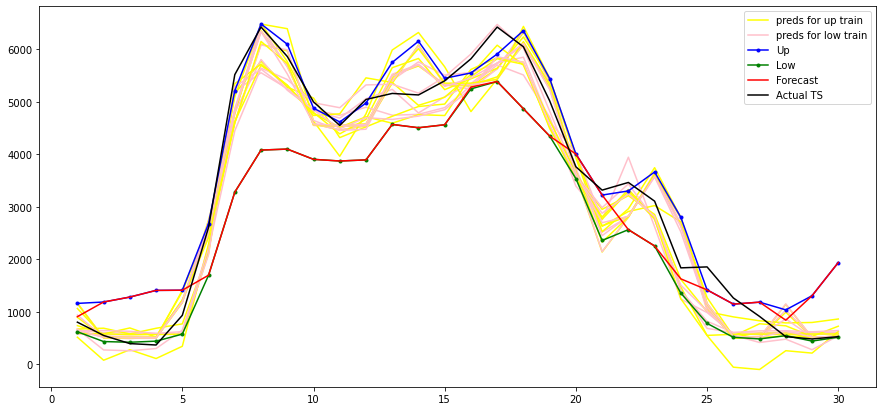

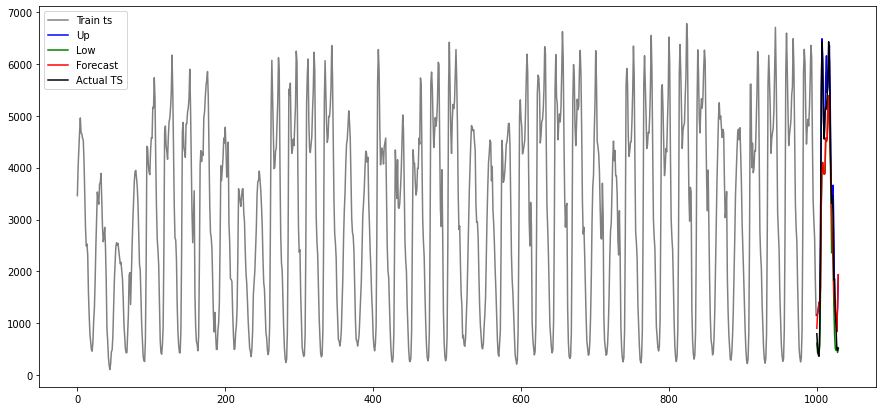

In [62]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = True,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)